In [1]:
import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
from jax import random
from numpyro.contrib.control_flow import scan
from numpyro.infer import MCMC, NUTS, Predictive
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

numpyro.set_host_device_count(n=4)

rng_key = random.PRNGKey(seed=42)

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
def demand_sales_dgp(rng_key, n):
    t = jnp.arange(start=0, stop=n, step=1)
    demand = 2 * jnp.ones_like(t, dtype=jnp.float32)
    sales = jnp.zeros_like(t, dtype=jnp.float32)
    sales_obs = jnp.zeros_like(t, dtype=jnp.float32)

    rng_key, rng_subkey = random.split(rng_key)
    noise_demand = 0.3 * random.normal(rng_subkey, shape=(t.size,))

    rng_key, rng_subkey = random.split(rng_key)
    noise_sales = 0.5 * random.normal(rng_subkey, shape=(t.size,))

    rng_key, rng_subkey = random.split(rng_key)
    is_available = random.bernoulli(rng_subkey, 0.88, shape=(t.size,)).astype(
        jnp.float32
    )

    for i in range(2, t.size):
        demand_i = (
            0.6 * demand[i - 1]
            + 0.3 * demand[i - 2]
            + 0.6 * jnp.sin(2 * jnp.pi * t[i] / 7)
            + 0.2
            + noise_demand[i]
        )
        demand_i = jnp.maximum(demand_i, 0)
        demand = demand.at[i].set(demand_i)  # noqa

        sales_i = demand[i] + noise_sales[i] - 0.2
        sales_i = jnp.minimum(sales_i, demand_i)
        sales_i = jnp.maximum(sales_i, 0)
        sales_i_obs = is_available[i] * sales_i
        sales_i_obs = jnp.minimum(sales_i_obs, 2.2)
        sales = sales.at[i].set(sales_i)  # noqa
        sales_obs = sales_obs.at[i].set(sales_i_obs)  # noqa

    return t, demand, sales, sales_obs, is_available


n = 180
rng_key, rng_subkey = random.split(rng_key)
t, demand, sales, sales_obs, is_available = demand_sales_dgp(rng_subkey, n)

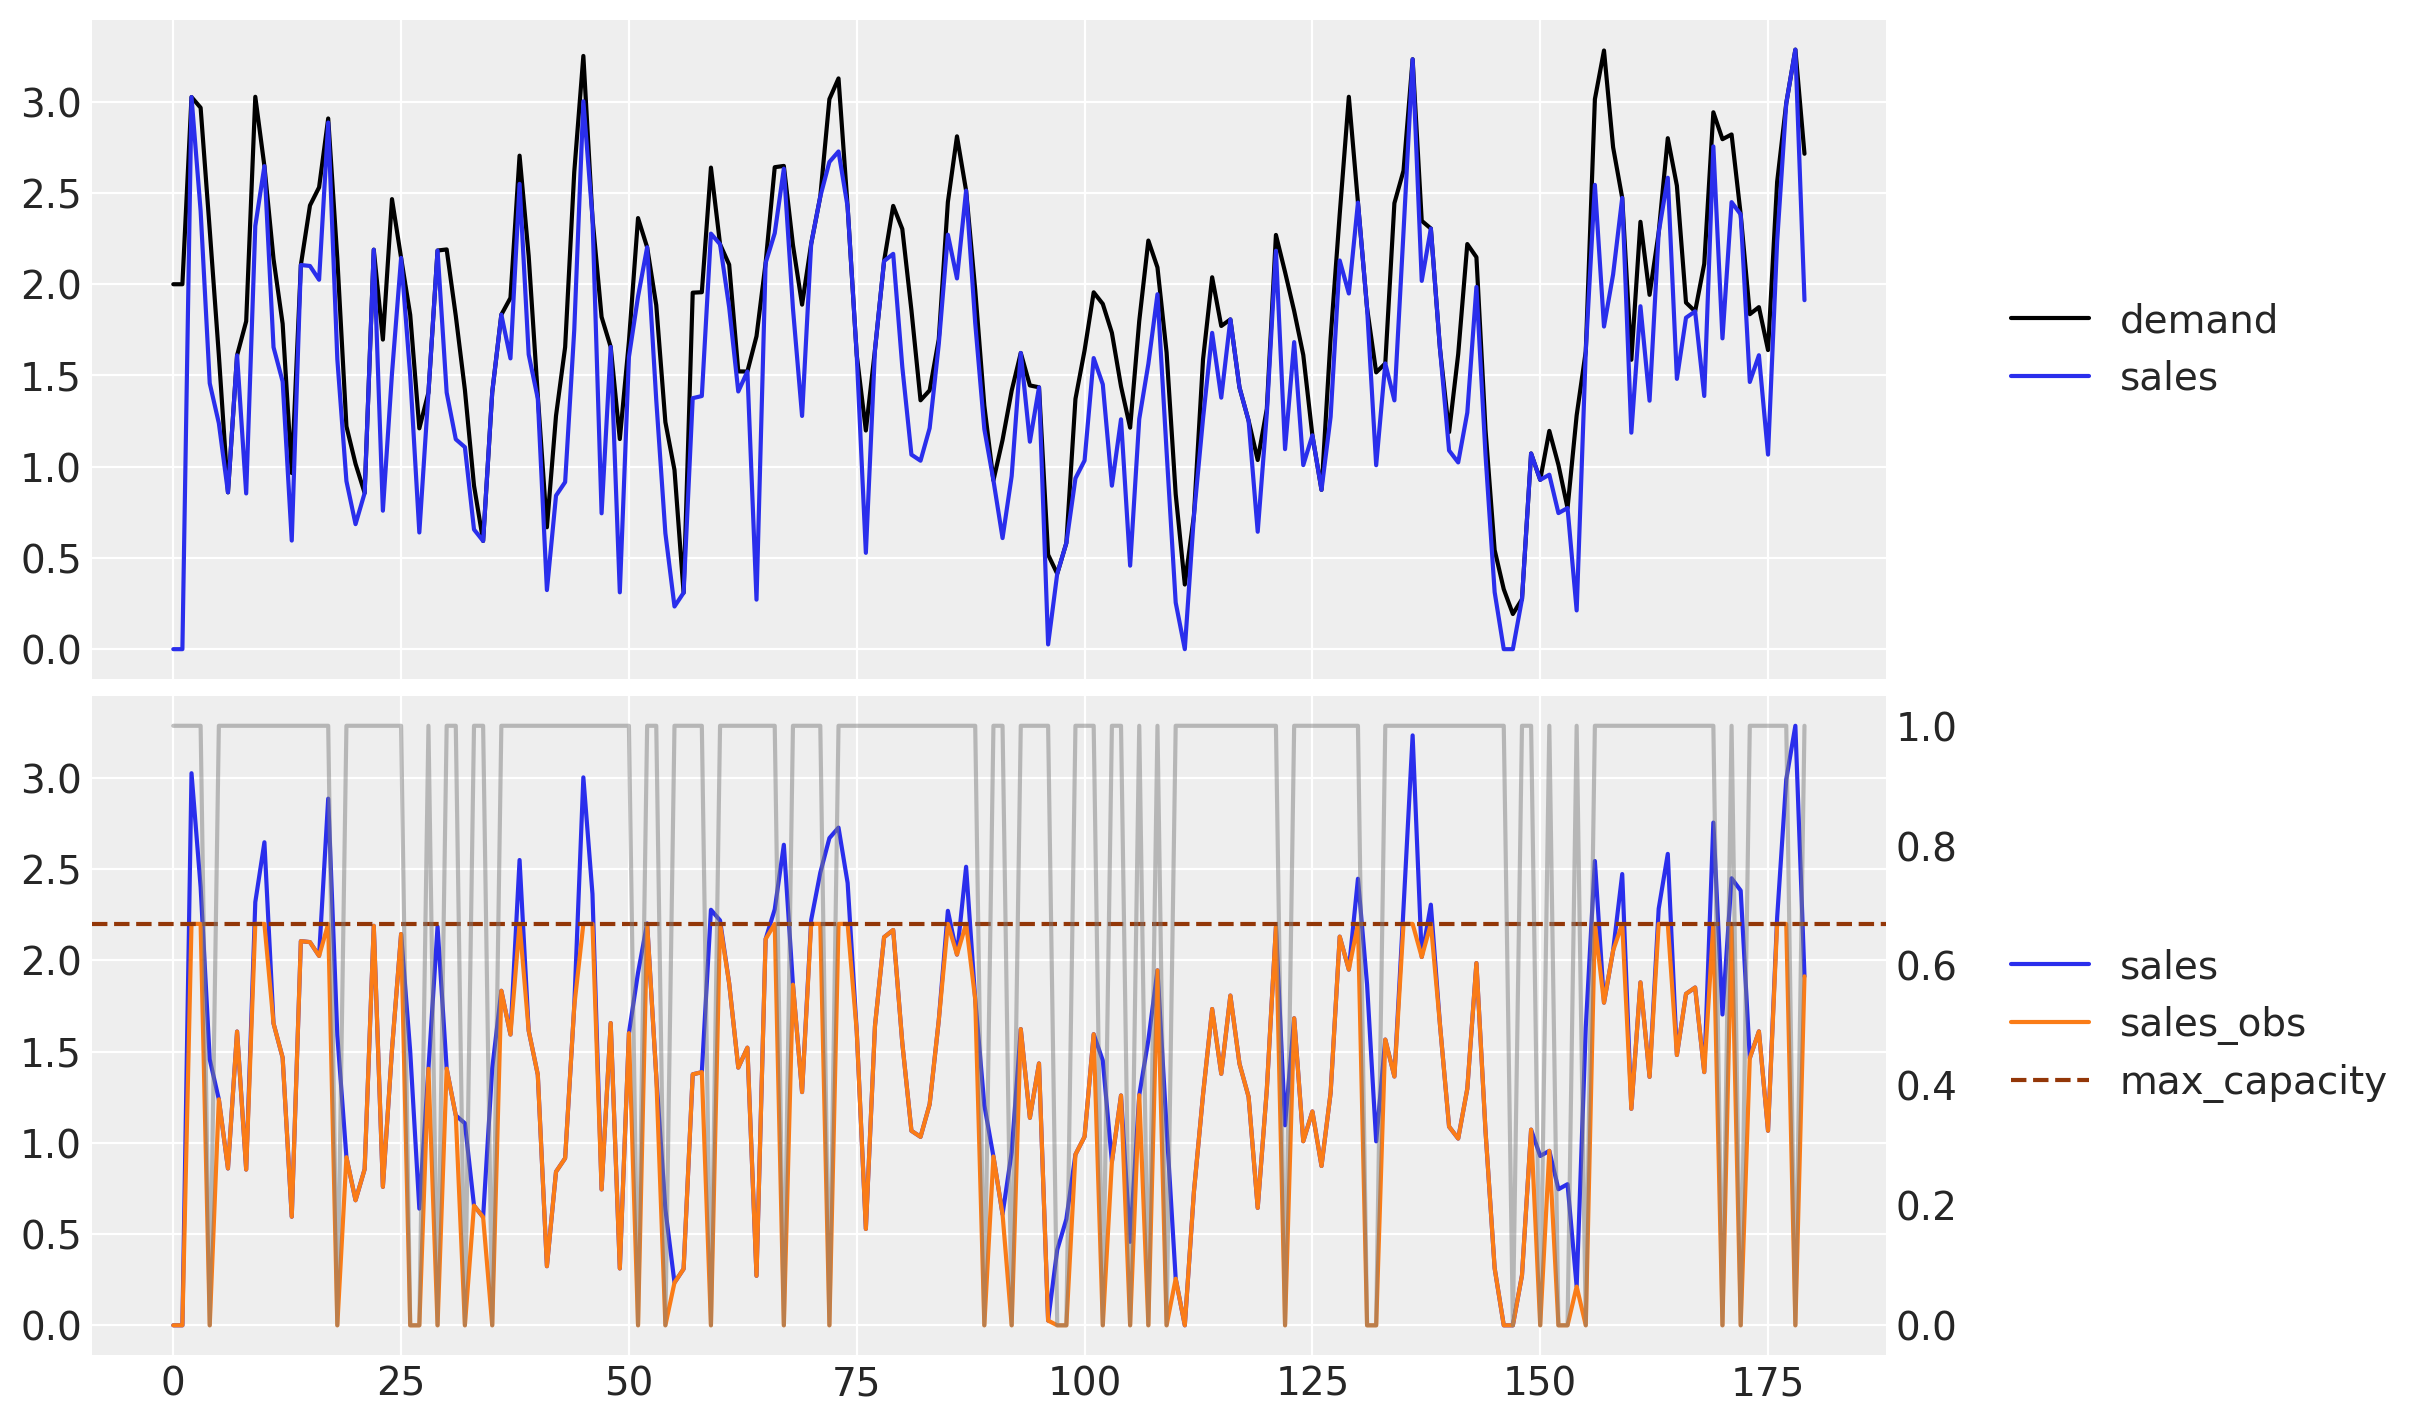

In [3]:
fig, ax = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(12, 7),
    sharex=True,
    sharey=True,
    layout="constrained",
)

ax[0].plot(t, demand, c="black", label="demand")
ax[0].plot(t, sales, c="C0", label="sales")
ax[0].legend(loc="center left", bbox_to_anchor=(1.05, 0.5))

ax[1].plot(t, sales, c="C0", label="sales")
ax[1].plot(t, sales_obs, c="C1", label="sales_obs")
ax1_twin = ax[1].twinx()
ax1_twin.plot(t, is_available, c="gray", alpha=0.5, label="is_available")
ax[1].axhline(2.2, color="C4", linestyle="--", label="max_capacity")
ax1_twin.grid(None)
ax[1].legend(loc="center left", bbox_to_anchor=(1.05, 0.5));

In [4]:
forecast_horizon = 30

t_train = t[:-forecast_horizon]
demand_train = demand[:-forecast_horizon]
sales_train = sales[:-forecast_horizon]
sales_obs_train = sales_obs[:-forecast_horizon]
is_available_train = is_available[:-forecast_horizon]
max_capacity_train = (sales_obs_train == 2.2).astype(int)

t_test = t[-forecast_horizon:]
demand_test = demand[-forecast_horizon:]
sales_test = sales[-forecast_horizon:]
sales_obs_test = sales_obs[-forecast_horizon:]
is_available_test = is_available[-forecast_horizon:]
is_available_test_expected = jnp.ones_like(is_available_test)
max_capacity_test_expected = jnp.zeros_like(sales_obs_test)

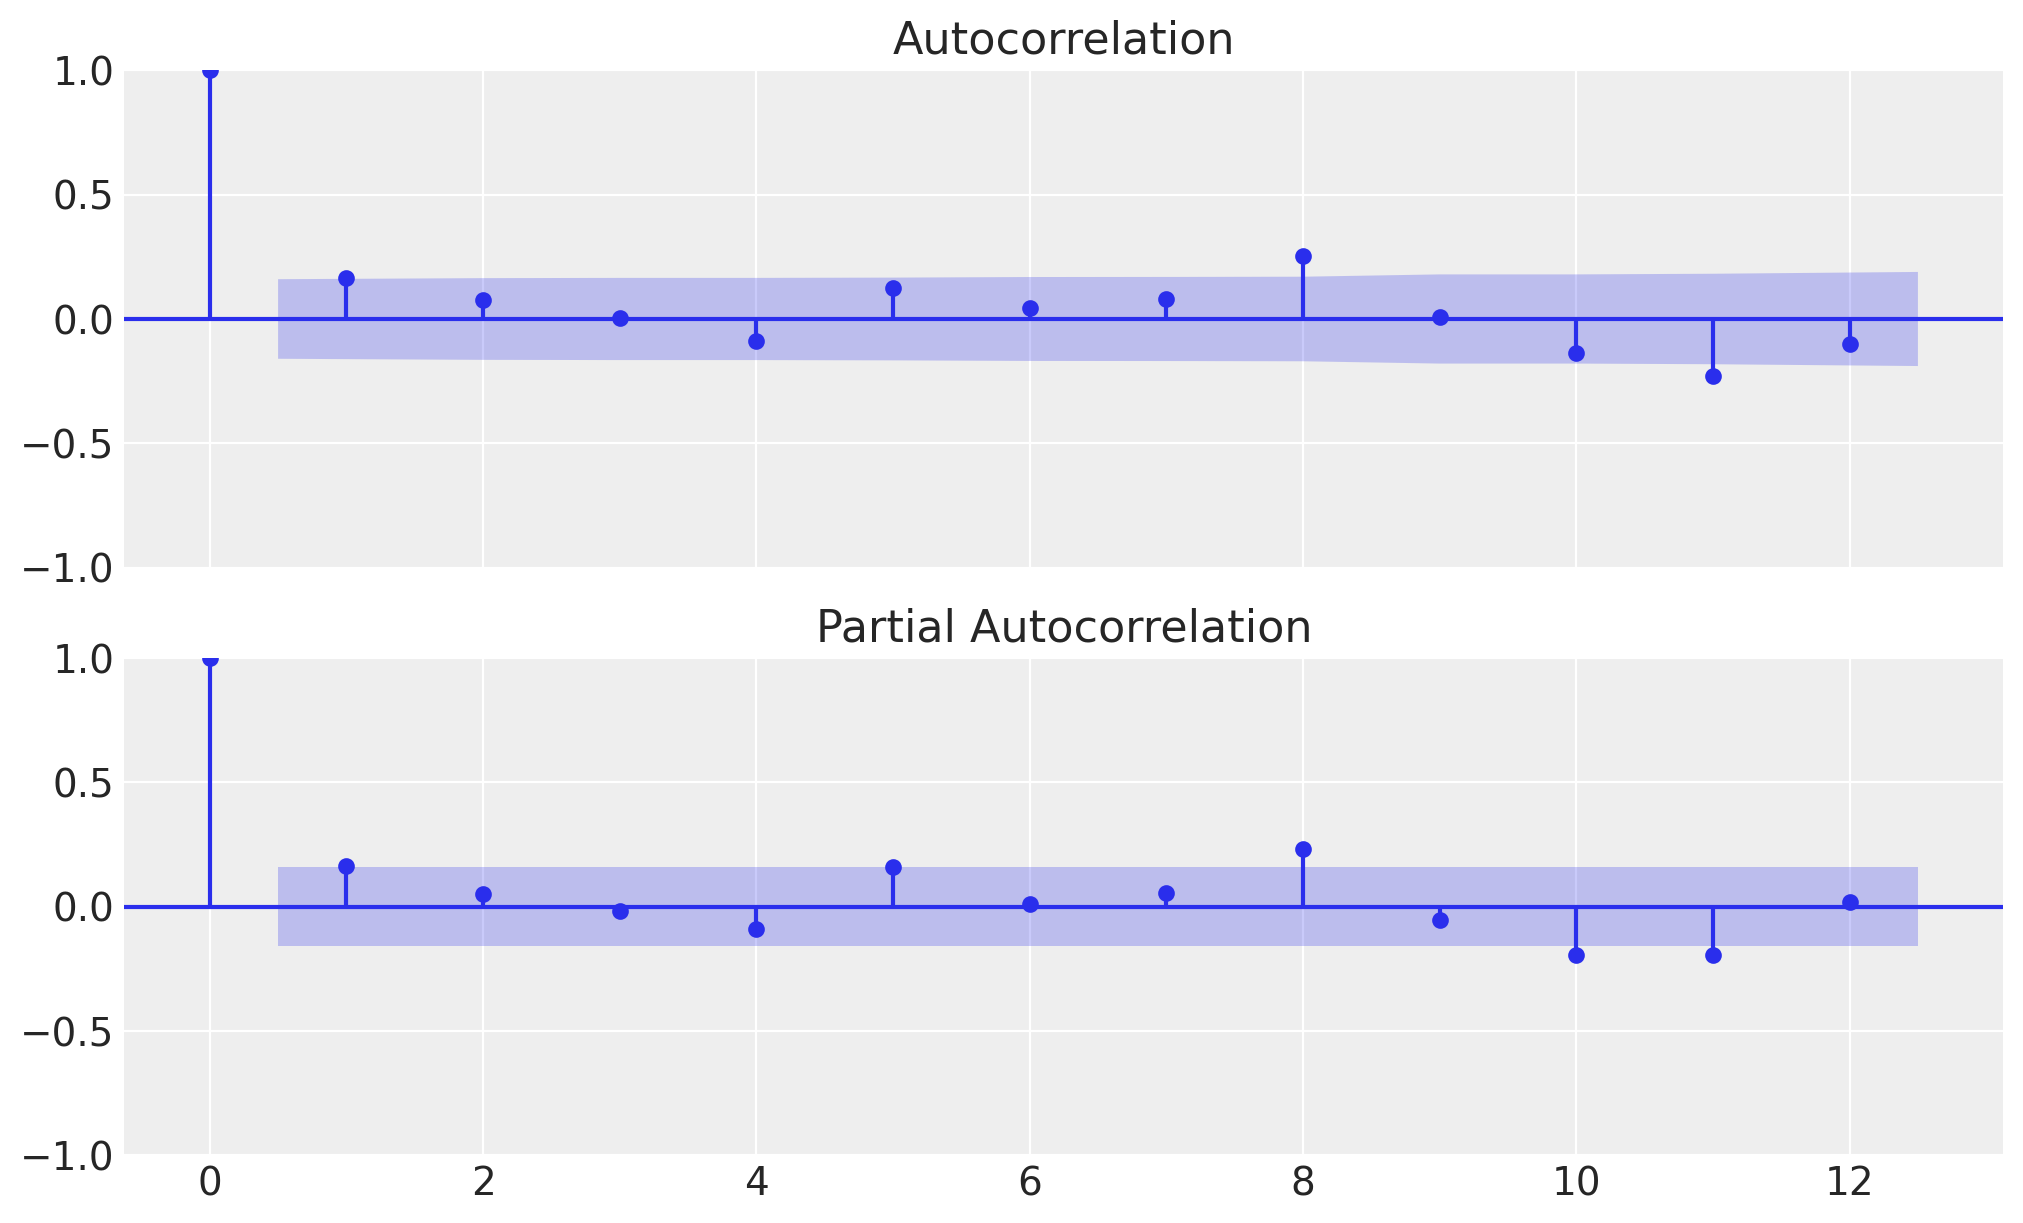

In [5]:
fig, ax = plt.subplots(
    nrows=2, ncols=1, sharex=True, sharey=True, figsize=(10, 6), layout="constrained"
)

_ = plot_acf(sales_obs_train, lags=12, ax=ax[0])
_ = plot_pacf(sales_obs_train, lags=12, ax=ax[1])

In [6]:
model = ARIMA(
    endog=np.asarray(sales_obs_train),
    exog=is_available_train,
    order=(1, 0, 0),
    seasonal_order=(1, 0, 0, 7),
)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                    
=======================================================================================
Dep. Variable:                               y   No. Observations:                  150
Model:             ARIMA(1, 0, 0)x(1, 0, 0, 7)   Log Likelihood                -121.384
Date:                         Mon, 15 Apr 2024   AIC                            252.768
Time:                                 23:14:54   BIC                            267.821
Sample:                                      0   HQIC                           258.883
                                         - 150                                         
Covariance Type:                           opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0420      0.229     -0.184      0.854      -0.490       0.406
x1             1.4301      0.199      7.199      0.000       1.041       1.819
ar.L1          0.2846      0.074      3.841      0.000       0.139       0.430
ar.S.L7        0.2345      0.094      2.490      0.013       0.050       0.419
sigma2         0.2945      0.040      7.360      0.000       0.216       0.373
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 5.47
Prob(Q):                              0.96   Prob(JB):                         0.06
Heteroskedasticity (H):               0.67   Skew:                            -0.45
Prob(H) (two-sided):                  0.16   Kurtosis:                         2.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

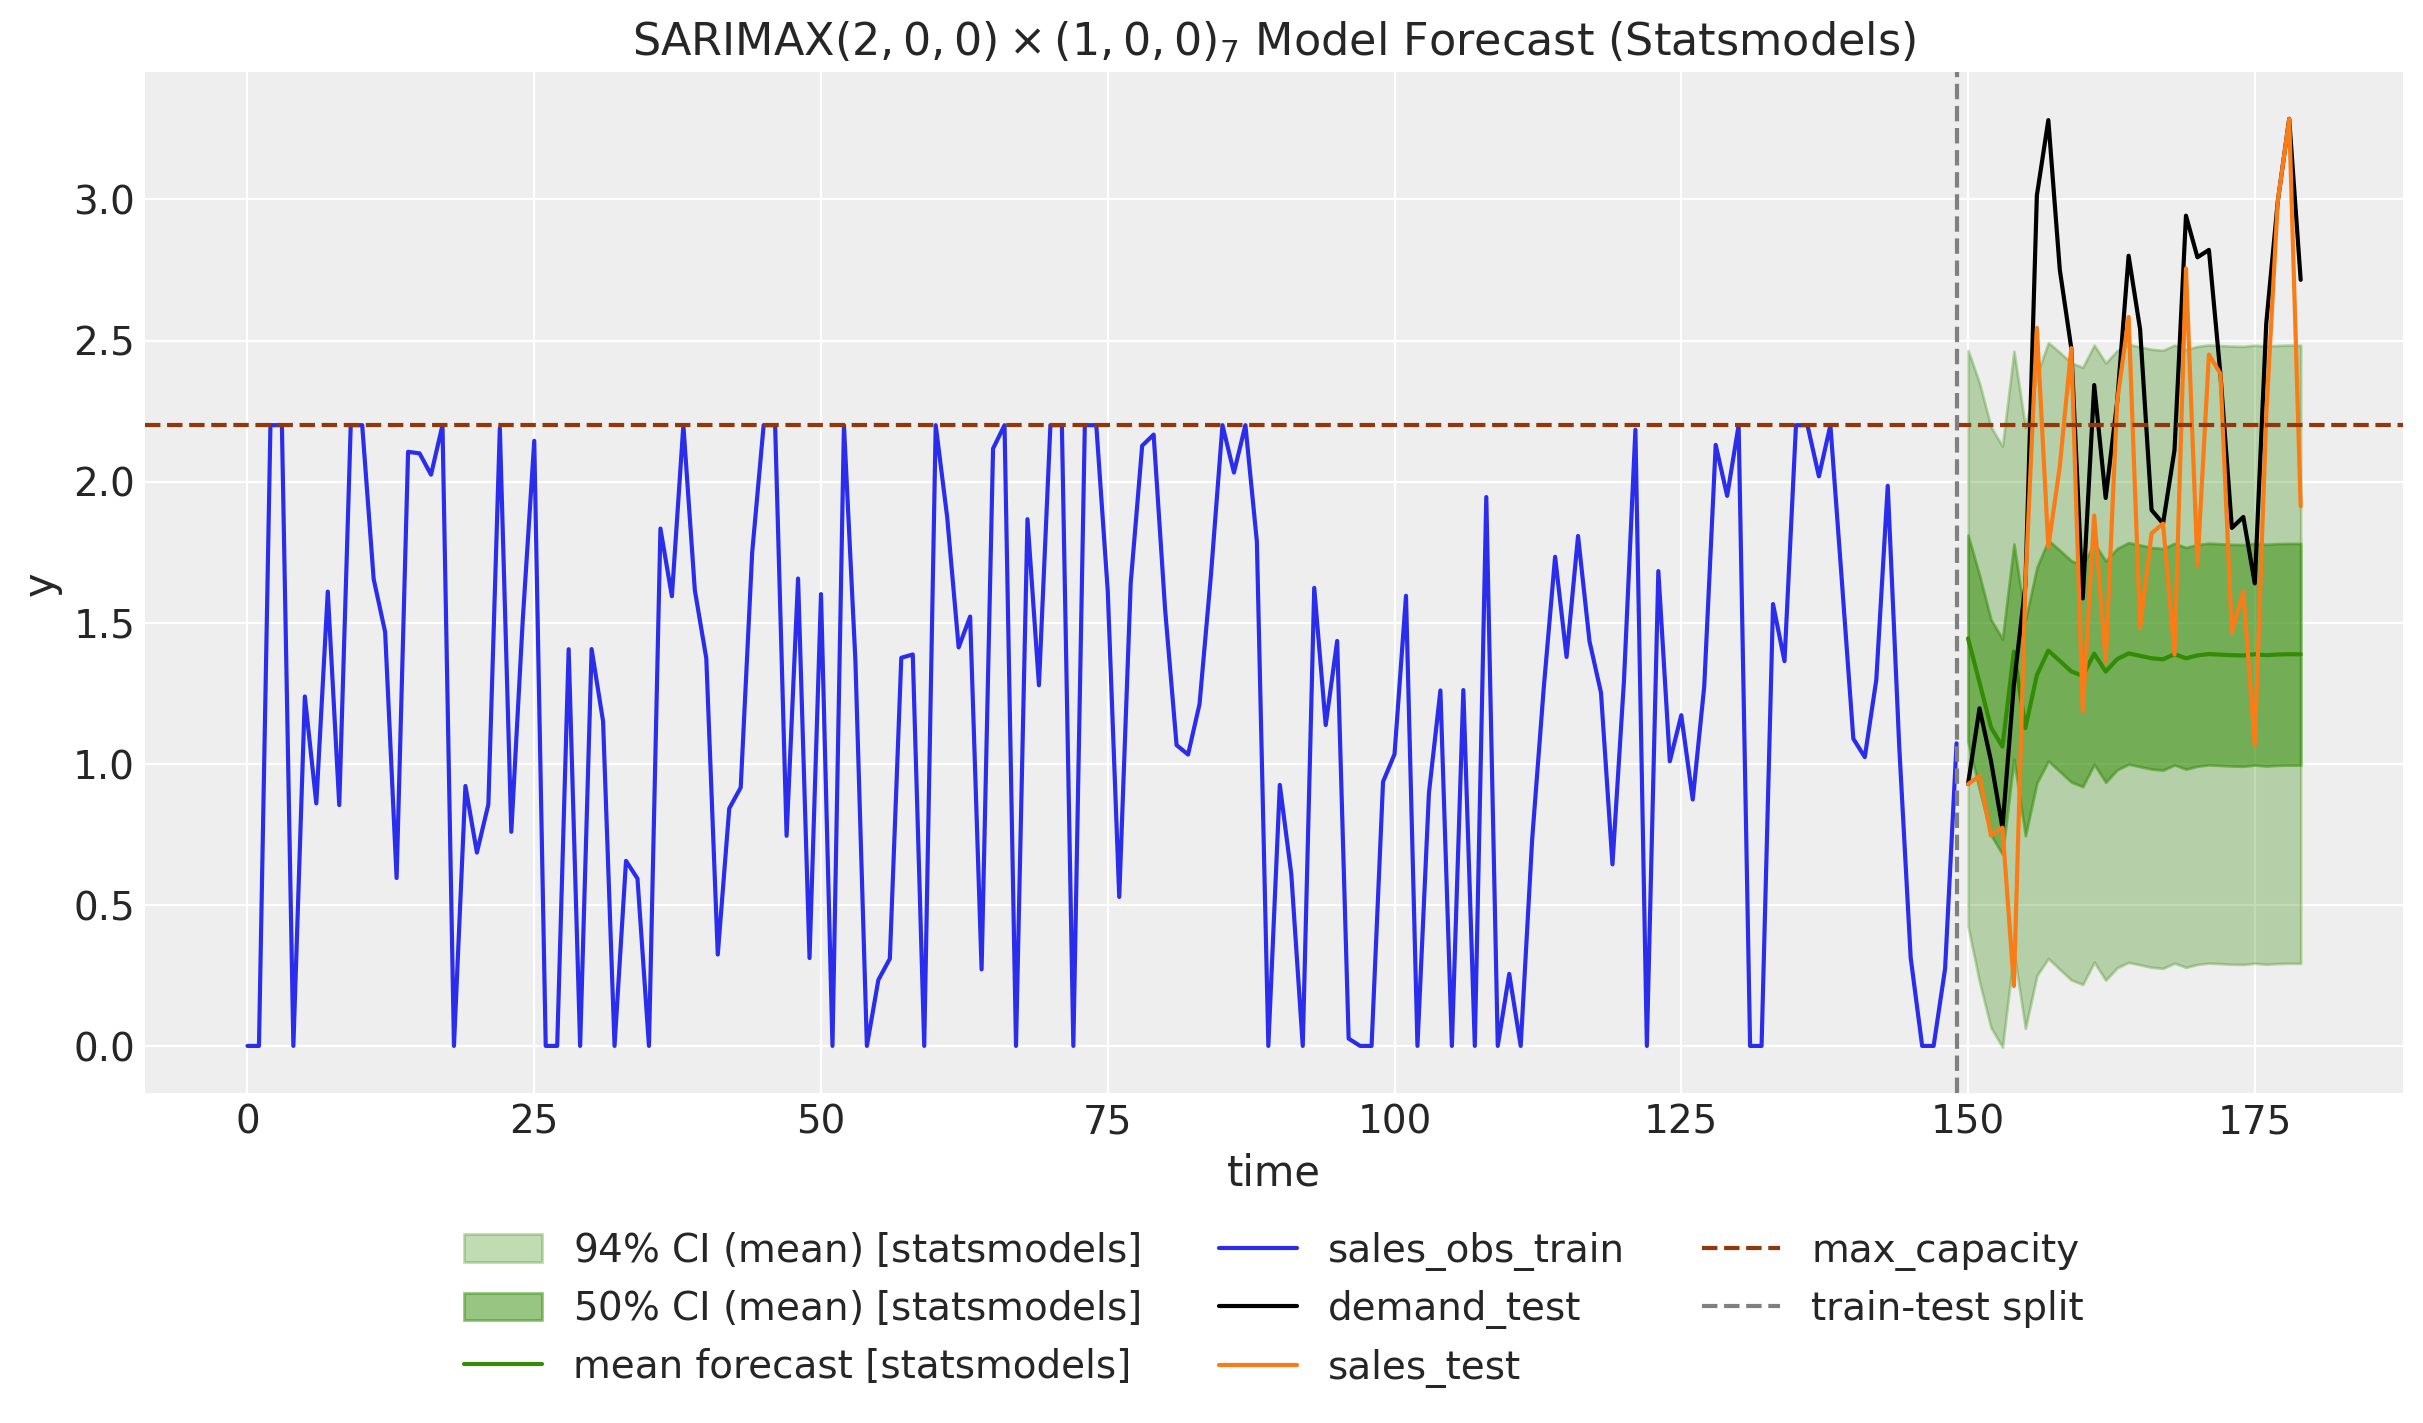

In [7]:
forecast_94_df = result.get_forecast(
    steps=sales_obs_test.size, exog=is_available_test_expected
).summary_frame(alpha=0.06)

forecast_50_df = result.get_forecast(
    steps=sales_obs_test.size, exog=is_available_test_expected
).summary_frame(alpha=0.5)

fig, ax = plt.subplots()
ax.fill_between(
    t_test,
    forecast_94_df["mean_ci_lower"],
    forecast_94_df["mean_ci_upper"],
    color="C2",
    alpha=0.3,
    label=r"$94\%$ CI (mean) [statsmodels]",
)
ax.fill_between(
    t_test,
    forecast_50_df["mean_ci_lower"],
    forecast_50_df["mean_ci_upper"],
    color="C2",
    alpha=0.5,
    label=r"$50\%$ CI (mean) [statsmodels]",
)
ax.plot(t_test, forecast_94_df["mean"], color="C2", label="mean forecast [statsmodels]")
ax.plot(t_train, sales_obs_train, color="C0", label="sales_obs_train")
ax.plot(t_test, demand_test, color="black", label="demand_test")
ax.plot(t_test, sales_test, color="C1", label="sales_test")
ax.axhline(y=2.2, c="C4", linestyle="--", label="max_capacity")
ax.axvline(x=t_train[-1], c="gray", linestyle="--", label="train-test split")
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=3)
ax.set(
    xlabel="time",
    ylabel="y",
    title="SARIMAX$(2, 0, 0)\\times(1, 0, 0)_{7}$ Model Forecast (Statsmodels)",
);

In [8]:
def seasonal_component(t, freq):
    beta_sin = numpyro.sample("beta_sin", dist.Normal(loc=0, scale=1))
    beta_cos = numpyro.sample("beta_cos", dist.Normal(loc=0, scale=1))
    sin_mode = beta_sin * jnp.sin(2 * jnp.pi * t / freq)
    cos_mode = beta_cos * jnp.cos(2 * jnp.pi * t / freq)
    return sin_mode + cos_mode


def censored_normal(loc, scale, y, censored):
    distribution = dist.Normal(loc=loc, scale=scale)
    ccdf = 1 - distribution.cdf(y)
    numpyro.sample(
        "censored_label", dist.Bernoulli(probs=ccdf).mask(censored == 1), obs=censored
    )
    return numpyro.sample("pred", distribution.mask(censored != 1))


def ar2_seasonal(t, y, is_available, censored, freq=7, future=0):
    t_max = y.size
    mu = numpyro.sample("mu", dist.Normal(loc=1, scale=1))
    phi_1 = numpyro.sample("phi_1", dist.Uniform(low=-1, high=1))
    phi_2 = numpyro.sample("phi_2", dist.Uniform(low=-1, high=1))
    sigma = numpyro.sample("sigma", dist.HalfNormal(scale=1))

    seasonal = seasonal_component(t, freq)

    def transition_fn(carry, t):
        y_prev_1, y_prev_2 = carry
        ar_part = phi_1 * y_prev_1 + phi_2 * y_prev_2
        pred_mean = mu + ar_part + seasonal[t]

        pred = is_available[t] * censored_normal(pred_mean, sigma, y[t], censored[t])
        return (pred, y_prev_1), pred

    init = (y[1], y[0])
    timesteps = jnp.arange(t_max - 2 + future)

    with numpyro.handlers.condition(
        data={"pred": y[2:], "is_available": is_available[2:], "censored": censored[2:]}
    ):
        _, preds = scan(transition_fn, init, timesteps)

    if future > 0:
        numpyro.deterministic("y_forecast", preds[-future:])

In [9]:
sampler = NUTS(ar2_seasonal, target_accept_prob=0.90)
mcmc = MCMC(sampler, num_warmup=1_000, num_samples=2_000, num_chains=4)
rng_key, rng_subkey = random.split(rng_key)
mcmc.run(
    rng_key=rng_subkey,
    t=t_train,
    y=sales_obs_train,
    is_available=is_available_train,
    censored=max_capacity_train,
)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

In [10]:
idata = az.from_numpyro(posterior=mcmc)

print(f"Divergences: {idata.sample_stats.diverging.sum().item()}")

Divergences: 0


In [11]:
idata = az.from_numpyro(
    posterior=mcmc, coords={"t_train": t_train[2:]}, dims={"pred": ["t_train"]}
)

var_names = ["mu", "phi_1", "phi_2", "beta_sin", "beta_cos", "sigma"]

az.summary(data=idata, var_names=var_names)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,0.934,0.149,0.666,1.224,0.002,0.001,4967.0,5613.0,1.0
phi_1,0.080,0.091,-0.089,0.248,0.001,0.001,6207.0,5566.0,1.0
phi_2,0.386,0.093,0.206,0.556,0.001,0.001,5592.0,4496.0,1.0
beta_sin,0.128,0.116,-0.095,0.345,0.001,0.001,6041.0,5026.0,1.0
beta_cos,0.264,0.106,0.062,0.454,0.001,0.001,6726.0,5768.0,1.0
sigma,0.838,0.056,0.734,0.943,0.001,0.000,6604.0,5013.0,1.0


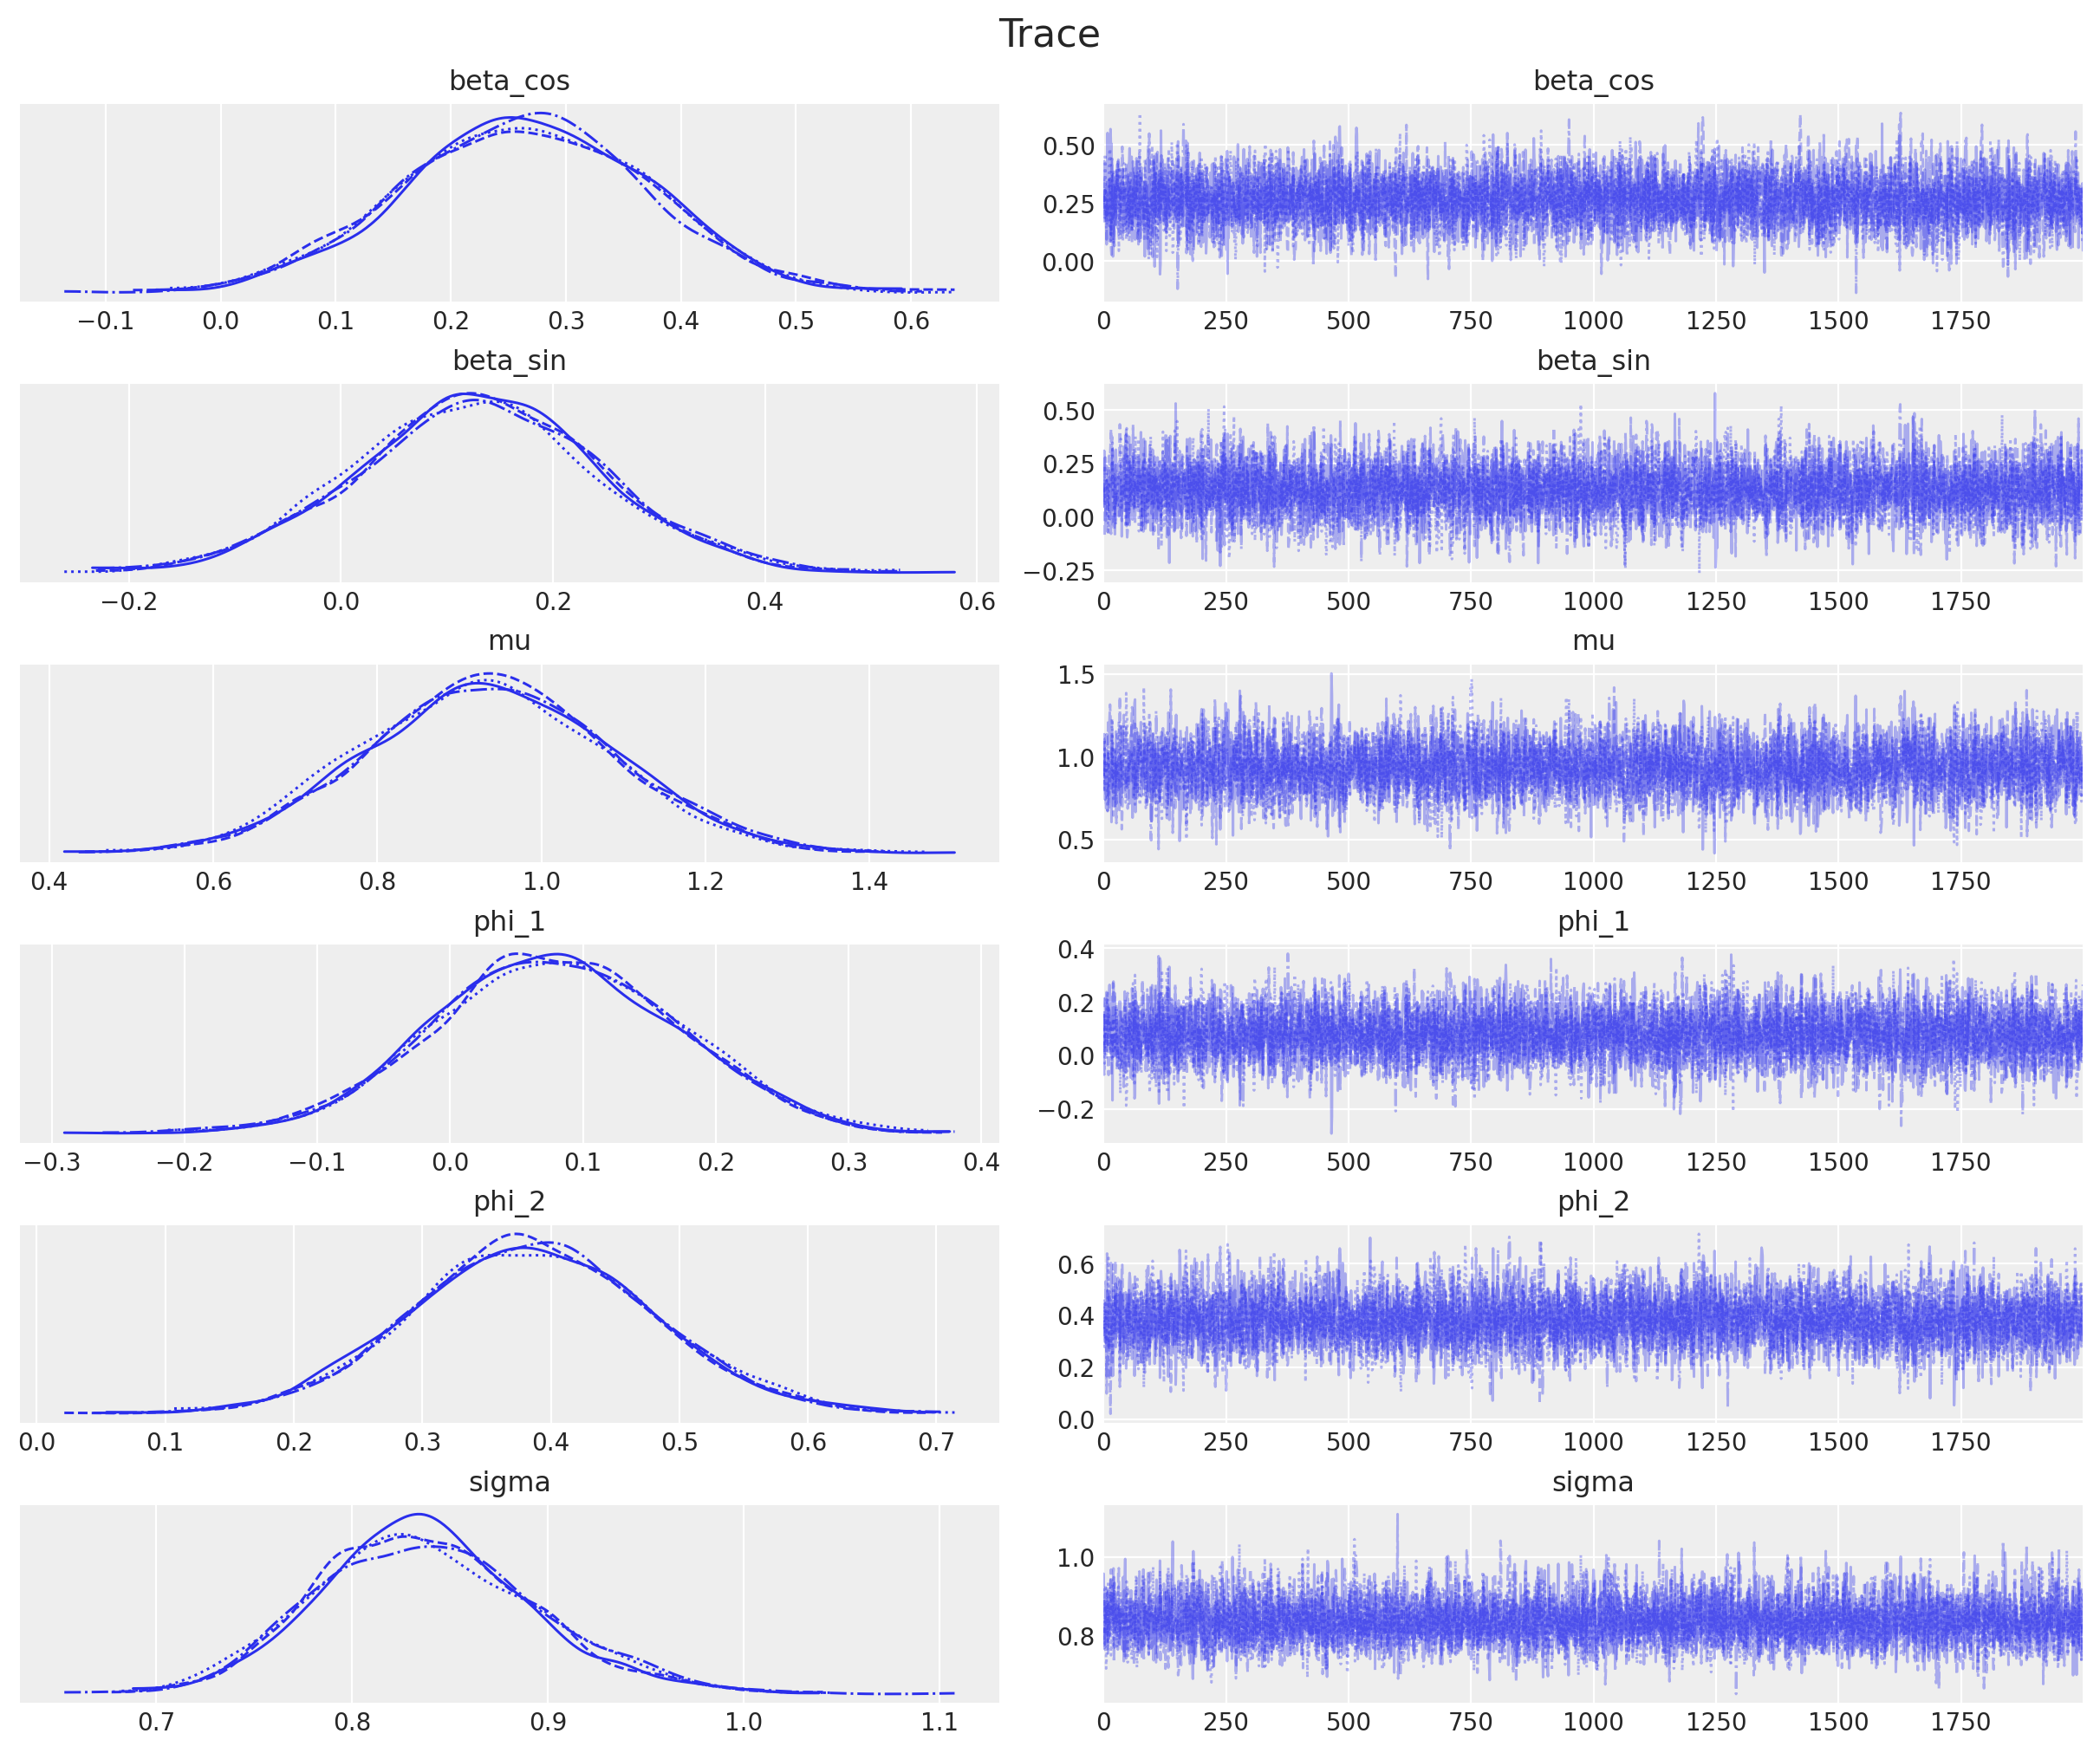

In [12]:
axes = az.plot_trace(
    data=idata,
    compact=True,
    backend_kwargs={"figsize": (12, 10), "layout": "constrained"},
)
plt.gcf().suptitle("Trace", fontsize=16);

In [13]:
predictive = Predictive(
    model=ar2_seasonal,
    posterior_samples=mcmc.get_samples(),
    return_sites=["y_forecast"],
)
rng_key, rng_subkey = random.split(rng_key)
forecast = predictive(
    rng_subkey,
    t=jnp.concatenate([t_train, t_test]),
    y=sales_obs_train,
    is_available=jnp.concatenate([is_available_train, is_available_test_expected]),
    censored=jnp.concat([max_capacity_train, max_capacity_test_expected], axis=0),
    future=forecast_horizon,
)

In [14]:
idata.extend(
    az.from_numpyro(
        posterior_predictive=forecast,
        coords={"t_test": t_test, "t": t},
        dims={"y_forecast": ["t_test"]},
    )
)

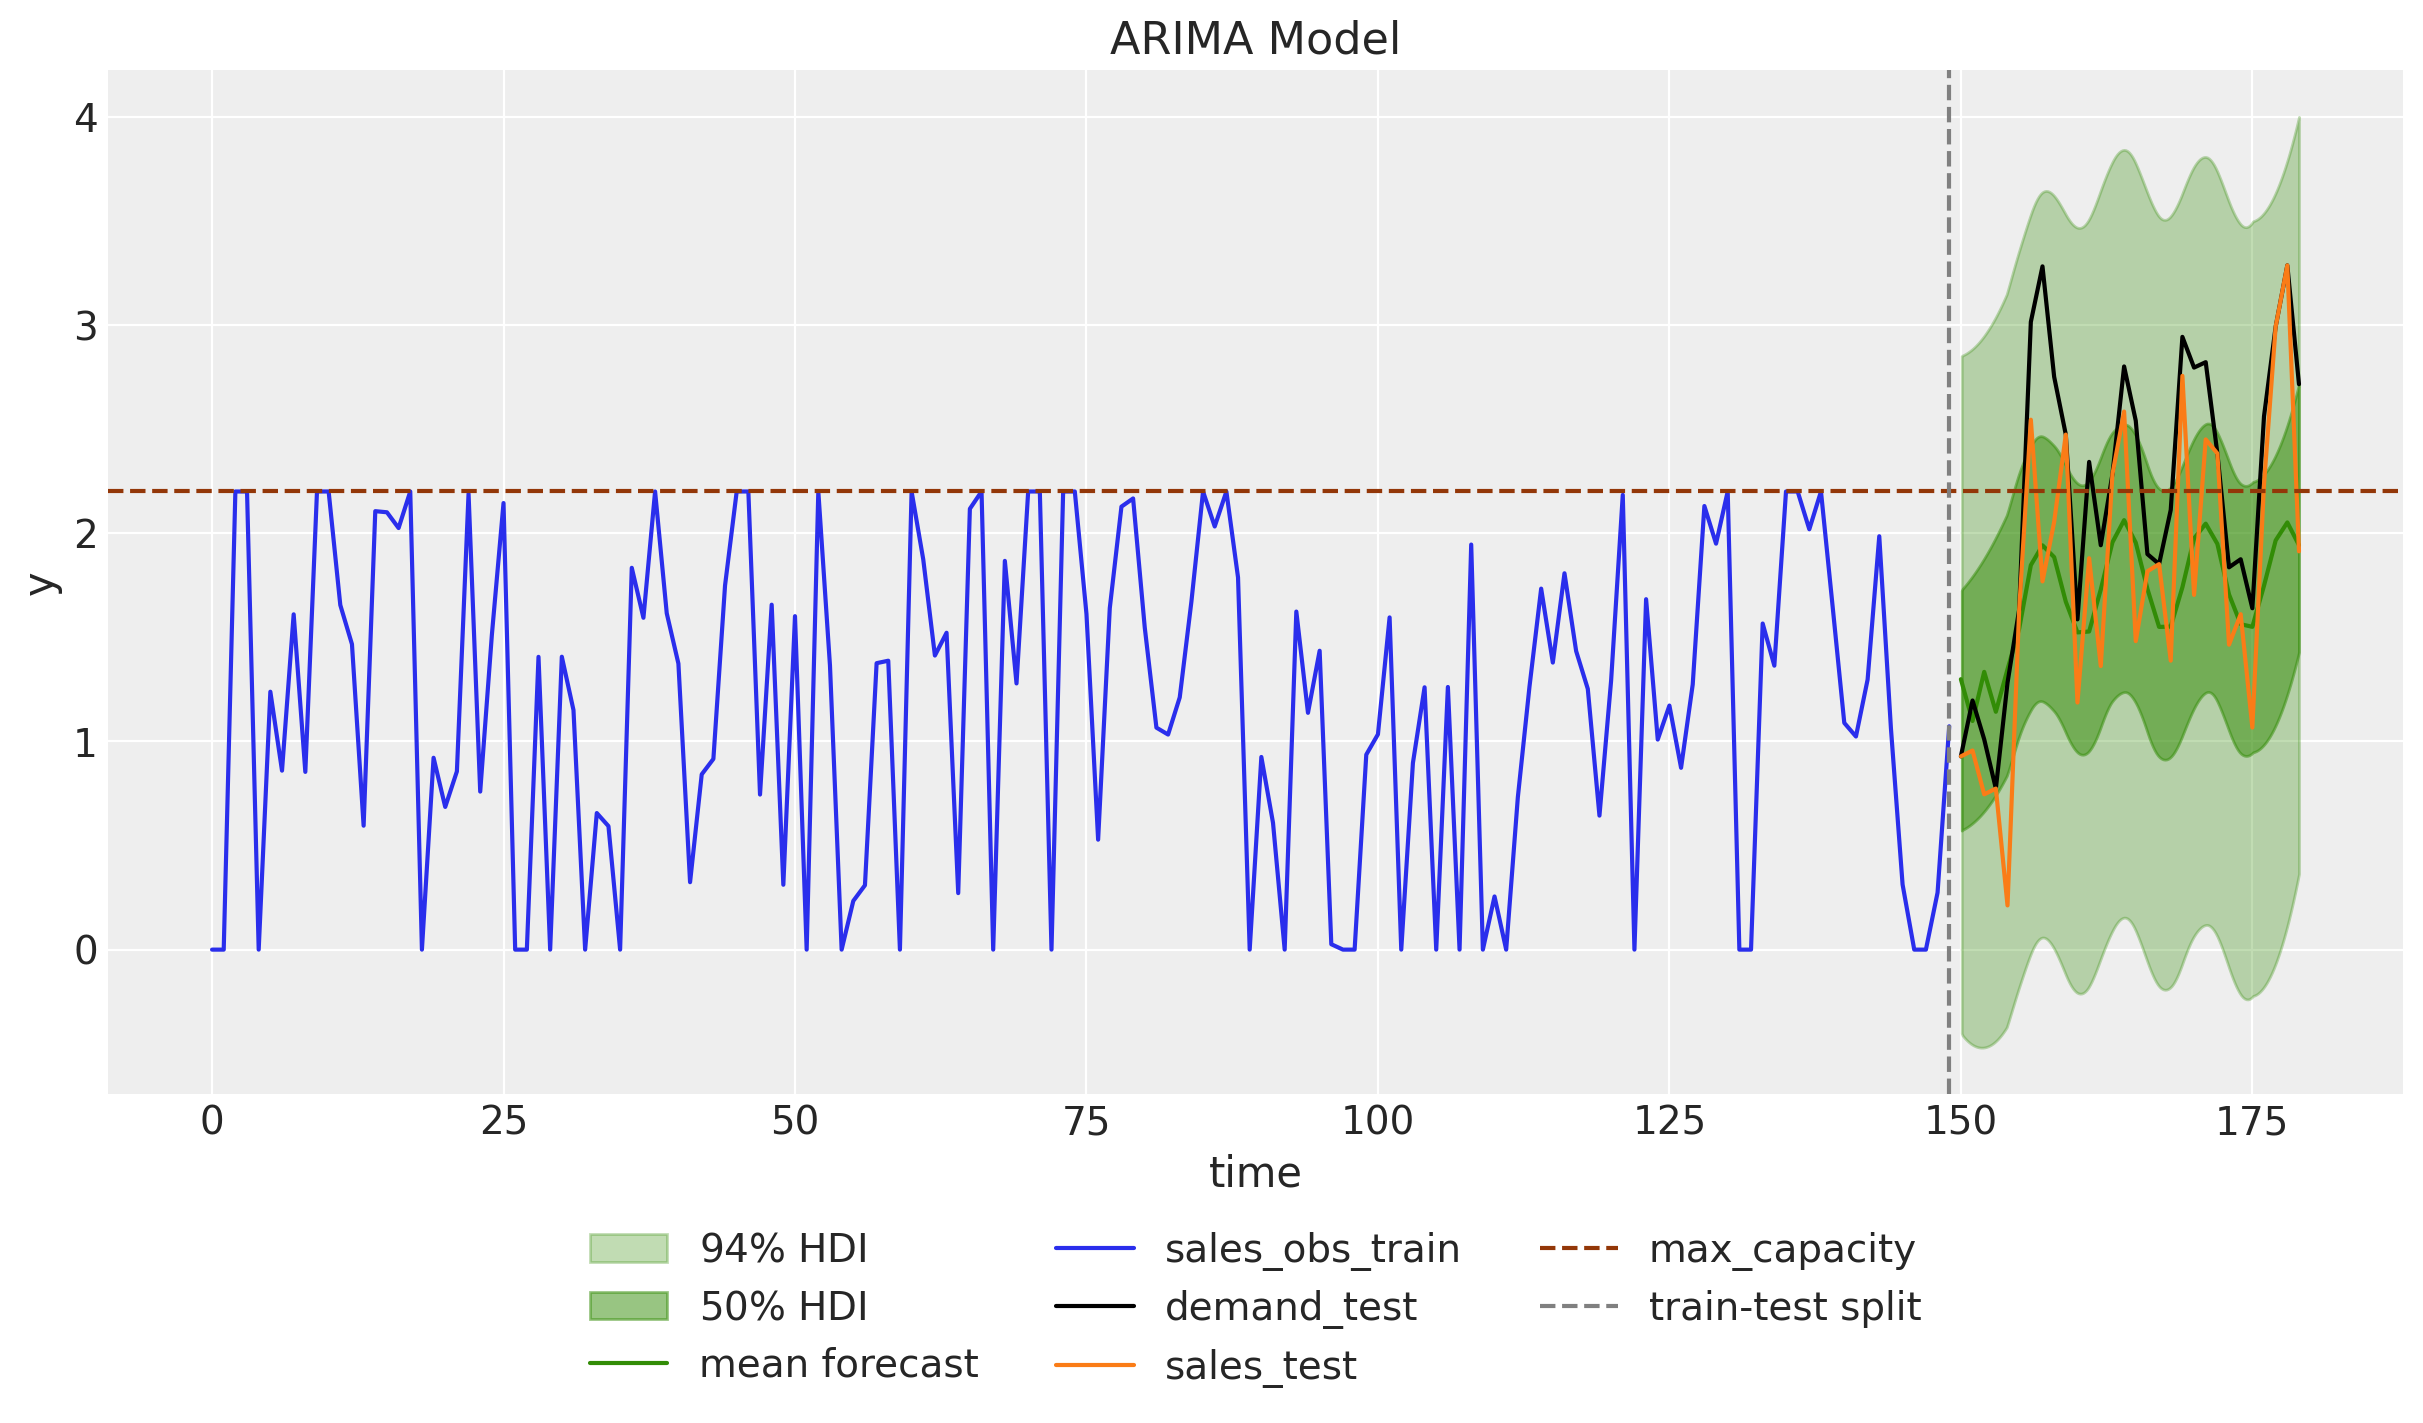

In [15]:
fig, ax = plt.subplots()
az.plot_hdi(
    t_test,
    idata.posterior_predictive["y_forecast"],
    hdi_prob=0.94,
    color="C2",
    fill_kwargs={"alpha": 0.3, "label": r"$94\%$ HDI"},
)
az.plot_hdi(
    t_test,
    idata.posterior_predictive["y_forecast"],
    hdi_prob=0.50,
    color="C2",
    fill_kwargs={"alpha": 0.5, "label": r"$50\%$ HDI"},
)
ax.plot(
    t_test,
    idata.posterior_predictive["y_forecast"].mean(dim=("chain", "draw")),
    color="C2",
    label="mean forecast",
)
ax.plot(t_train, sales_obs_train, color="C0", label="sales_obs_train")
ax.plot(t_test, demand_test, color="black", label="demand_test")
ax.plot(t_test, sales_test, color="C1", label="sales_test")
ax.axhline(y=2.2, c="C4", linestyle="--", label="max_capacity")
ax.axvline(x=t_train[-1], c="gray", linestyle="--", label="train-test split")
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=3)
ax.set(xlabel="time", ylabel="y", title="ARIMA Model");